## Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below.

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/Convolutional_Neural_Network'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['utils', 'custom_models.py']


### Setup Code

Run some setup code for this notebook: Import some useful packages

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# custom utils
import utils.utils as utils
import utils.data as data
import utils.modules as modules
import utils.layers as layers

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Load the CIFAR-10 dataset
 The utility function eecs598.data.preprocess_cifar10() returns the entire CIFAR-10 dataset as a set of six Torch tensors while also preprocessing the RGB images:

100%|██████████| 170498071/170498071 [00:01<00:00, 92630432.55it/s] 


Extracting ./cifar-10-python.tar.gz to .


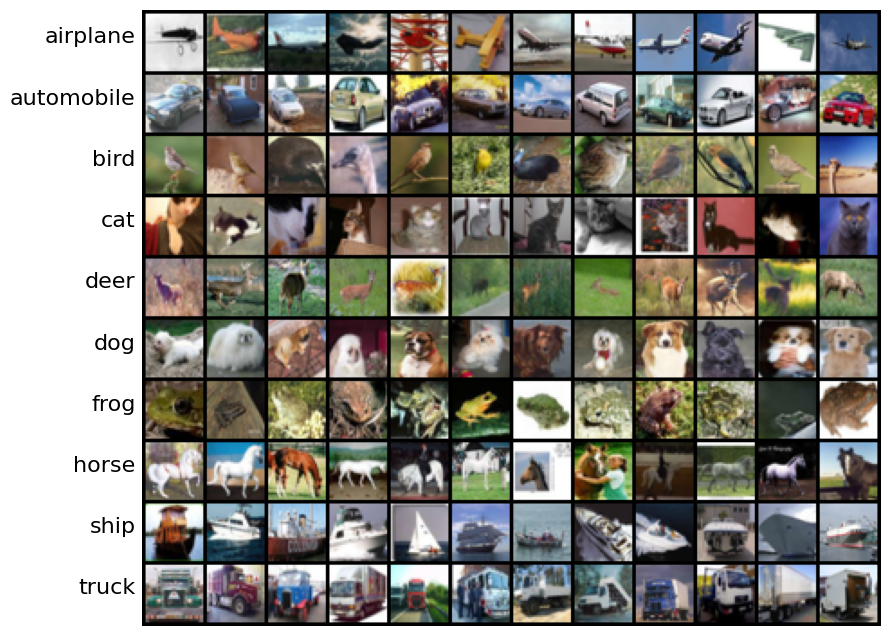

In [5]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=None,
                                                 show_examples=True,
                                                 flatten=False,
                                                 val_ratio=0.2)

data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
data_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
data_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

# ResNet
paper : [Deep Residual Learning for Image Recogmition](https://arxiv.org/pdf/1512.03385.pdf)

2015년도에 발표된 고전 논문이지만, 컴퓨터 비전에서 아직까지 많이 사용되는 모델이다. 논문이 발표되던 당시, layer을 깊게 쌓는 연구들이 활발히 진행되던 시기였다. 특히나, layer를 깊게 쌓을 경우 **vanishing / exploding gradient** 문제가 발생되고 이러한 문제를 해결하기 위해 고군분투했던 시기였다. ResNet논문 또한 이러한 흐름에 발표된 논문이다. 해당 논문은 **Residual networks are easier to optimize, and can gain accuracy from considerably incread depth.** 에 대한 주장으로 내용이 전개된다.

본 tutorial에서는 ResNet의 주요 Idea에 대해서 다루며 자세히 전체 내용을 다루지 않을 것이다. 궁금하면 논문을 읽어 보길 추천한다.

## Identity Mapping by Shortcuts

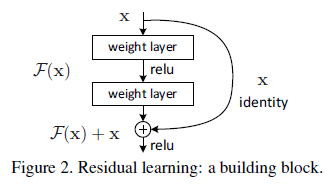

논문의 주요 Key Word는 **Identity Mapping**과 **Shortcut Connections**이다. ResidualBlock의 구조 자체는 위 그림 처럼 크게 복잡하지 않고 구현 또한 어렵지 않다.

$$y=F(x, \left\{W_i\right\})+x$$

> The function $F(x, \left\{W_i\right\})$ represents the residual mapping to be learned. $F=W_2σ(W_1x)$ in which σ denotes ReLU. The operation $F+x$ is performed by a **shortcut connection** and element-wise addition. The dimensions of $x$and $F$ must be equal in Eqn.(1). If this is not the case, we can perform a linear projection $W_s$ by the shortcut connection to match the dimensions:

$$y=F(x, \left\{W_i\right\})+W_sx$$

논문에 제공한 수식은 간단히 표현하기 위해 fully-connected layers로 표현이 되어있지만, 실제로는 convolutional layers이다. (수식에 혼동이 없길...)

> We also note that although the above notations are about fully-connected layers for simplicity, they are applicable to convolutional layers.

## ResidualBlock

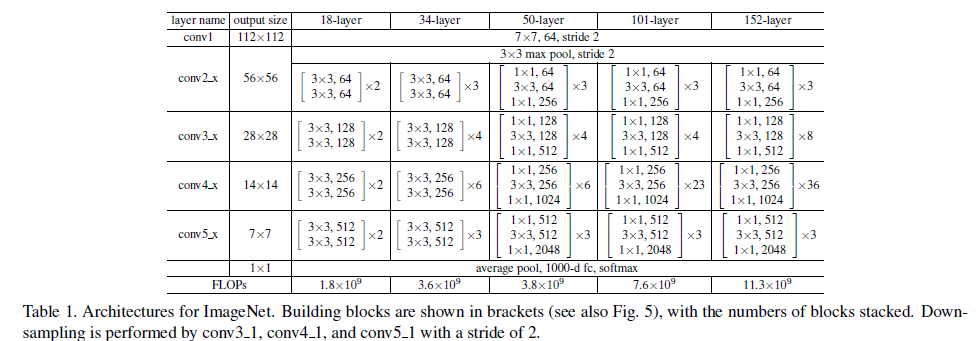

In [6]:
def _conv3x3(in_dim, out_dim, stride=1):
    return nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=stride, padding=1, bias=False)

def _conv1x1(in_dim, out_dim, stride=1):
    return nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=stride, bias=False)

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_dim, out_dim, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = _conv3x3(in_dim, out_dim, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.conv2 = _conv3x3(out_dim, out_dim, stride=1)
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.shortcut = nn.Sequential()

        if stride!=1 or in_dim != out_dim:
            self.shortcut = nn.Sequential(
                _conv1x1(in_dim, out_dim, stride=stride),
                nn.BatchNorm2d(out_dim)
            )

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = F.relu(out)

        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, block,
                 num_blocks,
                 num_filters=[64, 128, 256, 512],
                 strides=[1, 2, 2, 2],
                 cifar=True,
                 num_classes=10):
        super(ResNet, self).__init__()

        self.cifar = cifar

        if not cifar:
          self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
          self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = _conv3x3(3, 64, stride=1)

        self.bn1 = nn.BatchNorm2d(64)


        layers = []
        in_dim = num_filters[0]
        for i, out_dim in enumerate(num_filters):
          layers.append(self._make_layer(block, in_dim, out_dim, num_blocks[i], strides[i]))
          in_dim = out_dim

        self.blocks = nn.Sequential(*layers)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_dim, num_classes)

    def _make_layer(self, block, in_dim, out_dim, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []
        for stride in strides:
            layers.append(block(in_dim, out_dim, stride))
            in_dim = out_dim
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        if not self.cifar:
          out = self.max_pool(out)

        out = self.blocks(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [24]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

## Sanity Check

In [45]:
model = ResNet18()
criterion = nn.CrossEntropyLoss()

N = 50
x = torch.randn(N, 3, 32, 32)
y = torch.randint(10, size=(N,), dtype=torch.int64)

out = model(x)
loss = criterion(out, y)
print('loss : ', loss.item())

loss.backward()

loss :  2.5503902435302734


In [54]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=0.005,
                                                 show_examples=False,
                                                 flatten=False,
                                                 val_ratio=0.2)

print(f"number of train samples : {len(dset_train)}")
print(f"number of val samples : {len(dset_val)}")
print(f"number of test samples : {len(dset_test)}")

sample_loaders = {}
sample_loaders['train'] =  torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
sample_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
sample_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

history = utils.runner(model, criterion, optimizer, sample_loaders, num_epochs=30, msg=False)

number of train samples : 200
number of val samples : 50
number of test samples : 50
Train using cuda
Finished Training
Accuracy of the network on the 1 test images: 18.00%


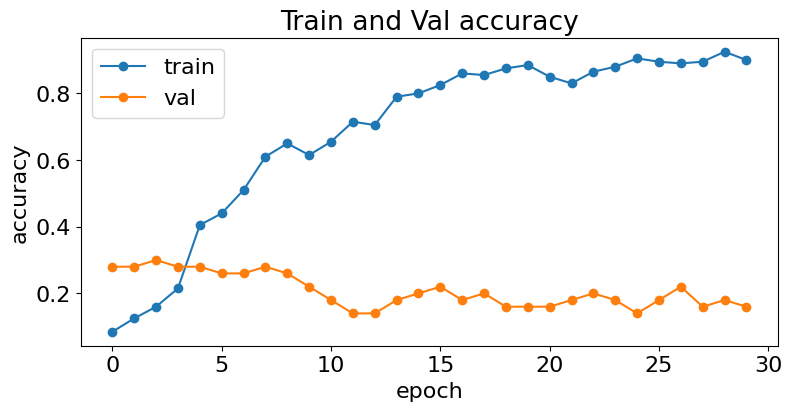

In [55]:
utils.visulaize_history(history['trainACC'], history['valACC'], title='accuracy')

## Train the Net

In [25]:
from torchvision.models import resnet18, resnet34
resnet = {'resnet18' : resnet18(pretrained=True),
          'resnet34' : resnet34(pretrained=True)}

my_resnet = {'resnet18': ResNet18,
            'resnet34': ResNet34}

In [18]:
model =  ResNet18()
model_state = model.state_dict()

pretrain_model = resnet18(pretrained=True)
pretrained_state_dict = pretrain_model.state_dict()
utils.check_model_state(pretrained_state_dict, model_state)

Param Name                                        Shape                Param Name                                        Shape
conv1.weight                                      (64, 3, 7, 7)        conv1.weight                                      (64, 3, 3, 3)
fc.weight                                         (1000, 512)          fc.weight                                         (10, 512)
fc.bias                                           (1000,)              fc.bias                                           (10,)


PyTorch에서 제공하는 사전학습된 resnet은 Imagenet으로 학습되어있다. 따라서, CIFAR-10을 사용하기 위해서는 수정이 필요하다. 첫번째 conv층과 마지막 fc를 제외한 parameter를 사용하여 모델을 학습시킨다.

In [19]:
def load_pretrained_state(model, model_frame):

  model_state = model.state_dict()
  pretrained_model = resnet[model_frame]
  pretrained_state_dict = pretrained_model.state_dict()

  for name, param in zip(model_state.keys(), pretrained_state_dict.values()):
    if name.startswith('conv1') or name.startswith('fc'):
        continue
    model_state[name].copy_(param)

  return model

In [38]:
def train(model_frame='resnet18', mode='train', lr=1e-3):

  model = my_resnet[model_frame]()

  if mode == 'finetune':
    model = load_pretrained_state(model, model_frame)

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  history = utils.runner(model, criterion, optimizer, data_loaders, num_epochs=10, msg=True)

  torch.save(model.state_dict(), f'{mode}_model.pth')

  return history

In [39]:
train_history = train(model_frame='resnet18', mode='train', lr=1e-3)

Train using cuda
Epoch [1/10]          train Loss: 1.8967          train ACC: 31.08%          val Loss: 1.6477          val ACC: 39.95%
Epoch [2/10]          train Loss: 1.5385          train ACC: 43.99%          val Loss: 1.4610          val ACC: 46.93%
Epoch [3/10]          train Loss: 1.3651          train ACC: 50.52%          val Loss: 1.3239          val ACC: 51.64%
Epoch [4/10]          train Loss: 1.2310          train ACC: 55.71%          val Loss: 1.2366          val ACC: 54.91%
Epoch [5/10]          train Loss: 1.1223          train ACC: 59.64%          val Loss: 1.1565          val ACC: 57.73%
Epoch [6/10]          train Loss: 1.0274          train ACC: 63.50%          val Loss: 1.0882          val ACC: 60.97%
Epoch [7/10]          train Loss: 0.9425          train ACC: 66.67%          val Loss: 1.0519          val ACC: 62.15%
Epoch [8/10]          train Loss: 0.8576          train ACC: 69.89%          val Loss: 1.0291          val ACC: 63.04%
Epoch [9/10]          train Los

In [40]:
finetune_history = train(model_frame='resnet18', mode='finetune', lr=5e-4)

Train using cuda
Epoch [1/10]          train Loss: 2.0363          train ACC: 27.75%          val Loss: 1.7591          val ACC: 40.01%
Epoch [2/10]          train Loss: 1.5785          train ACC: 45.81%          val Loss: 1.4443          val ACC: 50.25%
Epoch [3/10]          train Loss: 1.3182          train ACC: 54.69%          val Loss: 1.2470          val ACC: 56.85%
Epoch [4/10]          train Loss: 1.1459          train ACC: 60.50%          val Loss: 1.1063          val ACC: 61.19%
Epoch [5/10]          train Loss: 1.0174          train ACC: 65.22%          val Loss: 1.0099          val ACC: 65.40%
Epoch [6/10]          train Loss: 0.9198          train ACC: 68.60%          val Loss: 0.9200          val ACC: 68.16%
Epoch [7/10]          train Loss: 0.8437          train ACC: 71.29%          val Loss: 0.8591          val ACC: 70.27%
Epoch [8/10]          train Loss: 0.7807          train ACC: 73.34%          val Loss: 0.8041          val ACC: 72.16%
Epoch [9/10]          train Los

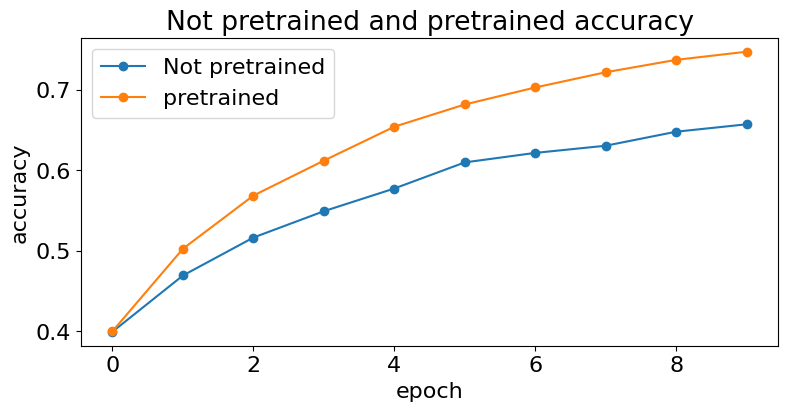

In [51]:
# utils.visulaize_history(train_history['trainACC'], train_history['valACC'], title='accuracy')
# utils.visulaize_history(finetune_history['trainACC'], finetune_history['valACC'], title='accuracy')
utils.compare_accuracy(train_history['valACC'], finetune_history['valACC'], names=['Not pretrained', 'pretrained'],title='accuracy')